## The Cancer Genome Atlas (TCGA) Data Exploration

In [196]:
import gcp.bigquery as bq
import scipy

### TCGA

TCGA is a National Institutes of Health and National Human Genome Institute project using high-throughput genomics technologies to characterize the genetic landscape of various human cancers in order to understand the genetic bases for human cancers, with the ultimate goal of improving diagnosis, treatment, and prevention.  Over two petabytes of data spanning 33 tumor types and 10 rare cancers from over 11,000 eligible volunteers has been gathered. Biotechniques used to gather molecular profiles on participant biospecimen include gene expression profiling, copy number variation profiling, SNP genotyping, genome wide DNA methylation profiling, microRNA profiling, and exon sequencing of at least 1,200 genes.  

### Data Background
* This data is available as a public dataset in Google's BigQuery and can be accessed through a Web-UI [here](https://bigquery.cloud.google.com/table/isb-cgc:tcga_201510_alpha).
* The TCGA 201510 dataset was curated by the Institute for Systems Biology Cancer Genomics Cloud (ISB-CGC) and is based on the open-access TCGA data available at the TCGA Data Portal as of October 2015.  The dataset includes 10 different tables: 

In [2]:
d = bq.DataSet('isb-cgc:tcga_201510_alpha')
for t in d.tables():
  print '%10d rows  %12d bytes   %s' \
      % (t.metadata.rows, t.metadata.size, t.name.table_id)

     17519 rows       6072735 bytes   Annotations
     23688 rows       6361090 bytes   Biospecimen_data
     11152 rows       4215264 bytes   Clinical_data
   2586033 rows     326181970 bytes   Copy_Number_segments
3874187076 rows  437382491205 bytes   DNA_Methylation_betas
   1618973 rows     180121639 bytes   Protein_RPPA_data
   5813281 rows    6392929246 bytes   Somatic_Mutation_calls
  38299138 rows    4459086535 bytes   mRNA_BCGSC_HiSeq_RPKM
 212475319 rows   25083953060 bytes   mRNA_UNC_HiSeq_RSEM
  13483548 rows    1644762154 bytes   miRNA_expression


* My analysis will focus solely on data found in the Clinical data table which contains clinical information about the participants in the study as well as some tumor-specific information.
* The goals of my analysis is to understand:
    * Explore the data available in the Clinical_data table
    * Understand the distribution of demographical representation in the participant population
    * Analyze correlation of various data points amongst participants with Ovarian serous cystadenocarcinoma 

## Clinical_data Dataset Overview

In [3]:
%%sql --module full_clinical_dataset
SELECT * 
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]

In [4]:
# clinical_data dataframe
cd = bq.Query(full_clinical_dataset).results().to_dataframe()
print 'There are {} columns in the Clinical_data table'.format(len(cd.columns))

There are 65 columns in the Clinical_data table


In [5]:
# Let's take a look at the schema of the Clinical data table - plethora of information!
%bigquery schema --table isb-cgc:tcga_201510_alpha.Clinical_data

In [6]:
print 'There exist {} rows of patient clinical information in the table.'.format(len(cd))

There exist 11152 rows of patient clinical information in the table.


In [7]:
# Let's take a peek at the data!
cd.sample(5)

,ParticipantBarcode,Study,Project,ParticipantUUID,TSSCode,age_at_initial_pathologic_diagnosis,anatomic_neoplasm_subdivision,batch_number,bcr,clinical_M,...,psa_value,race,residual_tumor,tobacco_smoking_history,tumor_tissue_site,tumor_type,venous_invasion,weight,height,BMI
1814,TCGA-4X-A9F9,THYM,TCGA,D542AA45-86CF-462E-ABBE-76A3354E707E,4X,57.0,None,431,Nationwide Children's Hospital,None,...,NaN,WHITE,None,None,Thymus,None,None,57.0,157.0,23.1
94,TCGA-WE-A8K5,SKCM,TCGA,0F579238-5A11-4ADC-9C80-572CBB2CE58F,WE,65.0,None,388,Nationwide Children's Hospital,None,...,NaN,WHITE,None,None,Extremities,None,None,NaN,NaN,NaN
7480,TCGA-OR-A5JJ,ACC,TCGA,9EC86C06-E7A9-4EA6-B36D-6F832909054B,OR,65.0,None,304,Nationwide Children's Hospital,M1,...,NaN,WHITE,R2,None,Adrenal,None,None,NaN,NaN,NaN
8878,TCGA-T2-A6X2,HNSC,TCGA,731F6967-5A01-40B7-9F88-64D980214BB2,T2,82.0,Alveolar Ridge,355,Nationwide Children's Hospital,M0,...,NaN,WHITE,None,Current reformed smoker for > 15 years,Head and Neck,None,None,NaN,NaN,NaN
3297,TCGA-EL-A3T1,THCA,TCGA,97D0E1BB-1459-4124-B25A-48195F2AD8B5,EL,38.0,None,230,Nationwide Children's Hospital,None,...,NaN,BLACK OR AFRICAN AMERICAN,R0,None,Thyroid,None,None,NaN,NaN,NaN


* From this peek into the data, we can see that not all fields are available for all patients.  For example, the height and weight are available for the first patient in the sample table but not for the other sample points.
* Understanding what values are available for which Study should be taken into consideration when developing a question for analysis.  There may be some fields that more correlated with some Studies.  For example, **tobacco_smoking_history** may strongly correlate with the **Lung adenocarcinoma** as tobacco is a known carcinogen and the act of smoking increases ones [risk](http://www.cancer.gov/about-cancer/causes-prevention/risk/tobacco/cessation-fact-sheet#q2) of developing lung cancer.

___________

## General Clinical Data Insights

### Which tumor type is most represented in the dataset?
* Each patient is in a 'Study' which denotes the tumor type 

In [255]:
%%sql --module number_of_studies
# Query for the distinct Studies
# BigQuery does not allow 'SELECT DISTINCT', so have to use 'GROUP BY'
SELECT
  CASE  
    WHEN Study IS NULL THEN 'OTHER'
    ELSE Study END AS TumorType
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]
GROUP BY TumorType

In [256]:
n_tumor_types = bq.Query(number_of_studies).results().to_dataframe()
print 'There are {} distinct tumor types represented in this population'.format(len(n_tumor_types))
print n_tumor_types.sample(5)

There are 33 distinct tumor types represented in this population
   TumorType
25      DLBC
11       UVM
2       STAD
3       LIHC
30      SARC


The tumor type is abbreviated and difficult to interpret, so we'll need to update the values with the full tumor type name.

In [10]:
%%sql --module tumor_type_representation

SELECT 
  CASE
      WHEN Study = 'LAML' THEN 'Acute Myeloid Leukemia'
      WHEN Study = 'ACC' THEN 'Adrenocortical carcinoma'
      WHEN Study = 'BLCA' THEN 'Bladder Urothelial Carcinoma'
      WHEN Study = 'LGG' THEN 'Brain Lower Grade Glioma'
      WHEN Study = 'BRCA' THEN 'Breast invasive carcinoma'
      WHEN Study = 'CESC' THEN 'Cervical squamous cell carcinoma and endocervical adenocarcinoma'
      WHEN Study = 'CHOL' THEN 'Cholangiocarcinoma'
      WHEN Study = 'COAD' THEN 'Colon adenocarcinoma'
      WHEN Study = 'ESCA' THEN 'Esophageal carcinoma'
      WHEN Study = 'FPPP' THEN 'FFPE Pilot Phase II'
      WHEN Study = 'GBM' THEN 'Glioblastoma multiforme'
      WHEN Study = 'HNSC' THEN 'Head and Neck squamous cell carcinoma'
      WHEN Study = 'KICH' THEN 'Kidney Chromophobe'
      WHEN Study = 'KIRC' THEN 'Kidney renal clear cell carcinoma'
      WHEN Study = 'KIRP' THEN 'Kidney renal papillary cell carcinoma'
      WHEN Study = 'LIHC' THEN 'Liver hepatocellular carcinoma'
      WHEN Study = 'LUAD' THEN 'Lung adenocarcinoma'
      WHEN Study = 'LUSC' THEN 'Lung squamous cell carcinoma'
      WHEN Study = 'DLBC' THEN 'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma'
      WHEN Study = 'MESO' THEN 'Mesothelioma'
      WHEN Study = 'OV' THEN 'Ovarian serous cystadenocarcinoma'
      WHEN Study = 'PAAD' THEN 'Pancreatic adenocarcinoma'
      WHEN Study = 'PCPG' THEN 'Pheochromocytoma and Paraganglioma'
      WHEN Study = 'PRAD' THEN 'Prostate adenocarcinoma'
      WHEN Study = 'READ' THEN 'Rectum adenocarcinoma'
      WHEN Study = 'SARC' THEN 'Sarcoma'
      WHEN Study = 'SKCM' THEN 'Skin Cutaneous Melanoma '
      WHEN Study = 'STAD' THEN 'Stomach adenocarcinoma'
      WHEN Study = 'TGCT' THEN 'Testicular Germ Cell Tumors '
      WHEN Study = 'THYM' THEN 'Thymoma'
      WHEN Study = 'THCA' THEN 'Thyroid carcinoma'
      WHEN Study = 'UCS' THEN 'Uterine Carcinosarcoma'
      WHEN Study = 'UCEC' THEN 'Uterine Corpus Endometrial Carcinoma'
      WHEN Study = 'UVM' THEN 'Uveal Melanoma'
      ELSE 'Other' END AS Study,
COUNT(*) AS number_of_participants
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]
GROUP BY Study
ORDER BY 2 DESC
LIMIT 10

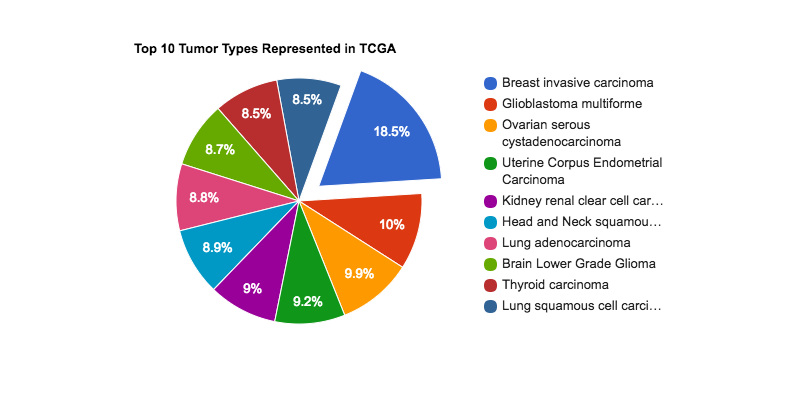

In [11]:
%%chart pie --fields Study,number_of_participants --data tumor_type_representation
title: Top 10 Tumor Types Represented in TCGA
height: 400
width: 800
pieStartAngle: 20
slices:
  0:
    offset: .2

* The percentages in the above pie chart represent the percentage of each tumor type represented amongst the top ten tumor types in the population. 
* Based on the above pie chart, participants with the tumor type of **Breast invasive carcinoma** are the most represented with 18.5% of the top ten most represented tumor types.  

### What's the distribution of tumor types across genders?

In [29]:
%%sql --module tumor_type_gender_breakdown
# this query uses BigQuery variable-notation to query based on gender
# BigQuery does not allow subquerying in SELECT

DEFINE QUERY study
SELECT
  (CASE
    WHEN Study = 'LAML' THEN 'Acute Myeloid Leukemia'
    WHEN Study = 'ACC' THEN 'Adrenocortical carcinoma'
    WHEN Study = 'BLCA' THEN 'Bladder Urothelial Carcinoma'
    WHEN Study = 'LGG' THEN 'Brain Lower Grade Glioma'
    WHEN Study = 'BRCA' THEN 'Breast invasive carcinoma'
    WHEN Study = 'CESC' THEN 'Cervical squamous cell carcinoma and endocervical adenocarcinoma'
    WHEN Study = 'CHOL' THEN 'Cholangiocarcinoma'
    WHEN Study = 'COAD' THEN 'Colon adenocarcinoma'
    WHEN Study = 'ESCA' THEN 'Esophageal carcinoma'
    WHEN Study = 'FPPP' THEN 'FFPE Pilot Phase II'
    WHEN Study = 'GBM' THEN 'Glioblastoma multiforme'
    WHEN Study = 'HNSC' THEN 'Head and Neck squamous cell carcinoma'
    WHEN Study = 'KICH' THEN 'Kidney Chromophobe'
    WHEN Study = 'KIRC' THEN 'Kidney renal clear cell carcinoma'
    WHEN Study = 'KIRP' THEN 'Kidney renal papillary cell carcinoma'
    WHEN Study = 'LIHC' THEN 'Liver hepatocellular carcinoma'
    WHEN Study = 'LUAD' THEN 'Lung adenocarcinoma'
    WHEN Study = 'LUSC' THEN 'Lung squamous cell carcinoma'
    WHEN Study = 'DLBC' THEN 'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma'
    WHEN Study = 'MESO' THEN 'Mesothelioma'
    WHEN Study = 'OV' THEN 'Ovarian serous cystadenocarcinoma'
    WHEN Study = 'PAAD' THEN 'Pancreatic adenocarcinoma'
    WHEN Study = 'PCPG' THEN 'Pheochromocytoma and Paraganglioma'
    WHEN Study = 'PRAD' THEN 'Prostate adenocarcinoma'
    WHEN Study = 'READ' THEN 'Rectum adenocarcinoma'
    WHEN Study = 'SARC' THEN 'Sarcoma'
    WHEN Study = 'SKCM' THEN 'Skin Cutaneous Melanoma '
    WHEN Study = 'STAD' THEN 'Stomach adenocarcinoma'
    WHEN Study = 'TGCT' THEN 'Testicular Germ Cell Tumors '
    WHEN Study = 'THYM' THEN 'Thymoma'
    WHEN Study = 'THCA' THEN 'Thyroid carcinoma'
    WHEN Study = 'UCS' THEN 'Uterine Carcinosarcoma'
    WHEN Study = 'UCEC' THEN 'Uterine Corpus Endometrial Carcinoma'
    WHEN Study = 'UVM' THEN 'Uveal Melanoma'
    ELSE 'Other' END) As Study,
  Gender,
  COUNT(*) AS percent_participants
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]
GROUP BY
  Study,
  Gender
HAVING Gender = $gender

DEFINE QUERY total
SELECT Gender, COUNT(*) AS number_of_cases
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]
GROUP BY Gender

DEFINE QUERY test
SELECT 
  f.Study AS Study, 
  f.percent_participants / t.number_of_cases * 100 AS percent_participants 
FROM ( $study ) AS f
LEFT JOIN ( $total ) AS t 
ON t.Gender = f.Gender
ORDER BY 2 DESC, 1

In [30]:
# generate gender-specific dataframes and fill in NULL/NaN fields with 0
females = bq.Query(tumor_type_gender_breakdown,gender='FEMALE').results().to_dataframe().fillna(0)
males = bq.Query(tumor_type_gender_breakdown,gender='MALE').results().to_dataframe().fillna(0)

# rename columns
females.columns = ['Study', 'female percent participants']
males.columns = ['Study', 'male percent participants']

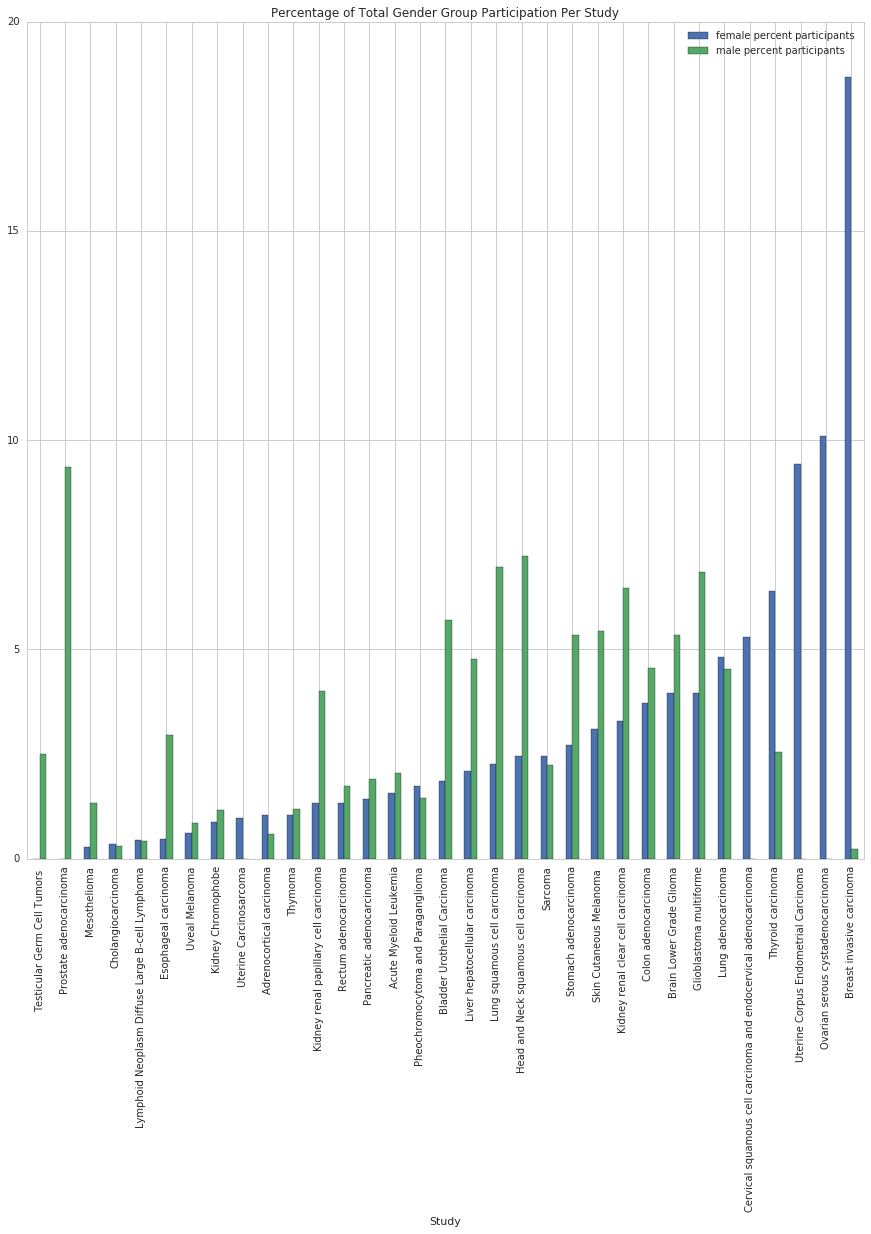

In [263]:
import pandas as pd
# full outer merge on the female and male dataframes
pd.merge(females, males, how='outer', on='Study', sort=True, copy=True, indicator=False).fillna(0).sort_values(by='female percent participants')
plt.plot(kind='bar', x='Study', title='Percentage of Total Gender Group Participation Per Study', figsize=(15, 15))

* The above graph depicts the percentage of cases of a tumor type with a gender over the total number of cases within that gender.  Bar groups are per study/tumor type.
* Data sorted by "female percent participants" and illustrates some expected -- 0 women for male-specific tumor types based (**testicular germ cell tumor**, **prostate adenocarcinoma**) and 0 men with female-specific tumor types (**uterine corpus endometrial carcinoma** and **ovarian serous cystadenocarcinoma**)
* According to [National Cancer Institute](http://www.cancer.gov/types/breast/patient/male-breast-treatment-pdq), male breast cancer represents less than 1% of all cancers of breast cancer. 

### What's the distribution of ages at initial diagnosis represented in this cohort?

In [32]:
%%sql --module age_distribution
# gather all ages, filtering out patients where age is unknown
SELECT age_at_initial_pathologic_diagnosis
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]
WHERE age_at_initial_pathologic_diagnosis IS NOT NULL

In [33]:
# snapshot of age at time of diagnosis
df_ages = bq.Query(age_distribution).results().to_dataframe()
df_ages.describe()

,age_at_initial_pathologic_diagnosis
count,11102.000000
mean,59.092866
std,14.419329
min,10.000000
25%,50.000000
50%,60.000000
75%,70.000000
max,90.000000


In [71]:
%%sql --module age_group_distribution
SELECT 
  age_at_initial_pathologic_diagnosis 
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]

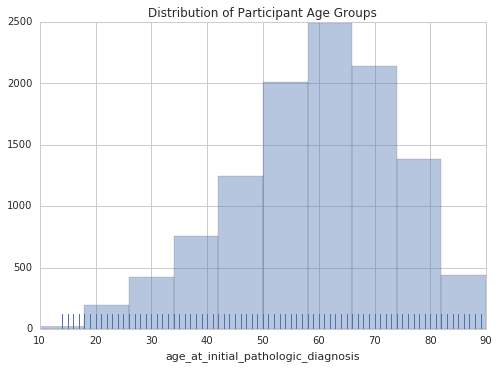

In [77]:
df_age = bq.Query(age_group_distribution).results().to_dataframe().dropna()
import seaborn as sns
sns.distplot(df_age, bins=10, kde=False, rug=True)
plt.title("Distribution of Participant Age Groups")
plt.xlabel('age_at_initial_pathologic_diagnosis')

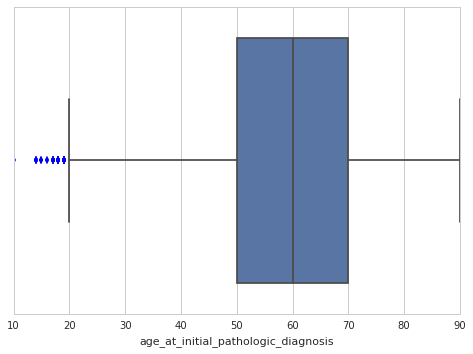

In [76]:
sns.boxplot(x=df_age['age_at_initial_pathologic_diagnosis'])

* I use 3 different methods to observe the distribution of age_at_time_of_diagnosis -- a box-and-whisker plot, histogram where ages are spread across 10 bins, and a table holding the stastical information.
* Participant ages are slightly skewed right with a mean age of **59.09** and a standard deviation of **14.42**.
* According to the box-and-whisker plot, there are 7 outliersin the under 20 age group.

### What's the distribution of race across Studies?

* In one of the queries below, `participant_races`, I query for the distinct races represented in the population.
* The results from this query will be used to iterate over and feed each value into the `tumor_type_race_breakdown` query.
* In the for-loop, I will create a graph of studies were each race has the ten highest amont of participation across its subpopulation.

In [48]:
%%sql --module tumor_type_race_breakdown

DEFINE QUERY study
SELECT
  (CASE
    WHEN Study = 'LAML' THEN 'Acute Myeloid Leukemia'
    WHEN Study = 'ACC' THEN 'Adrenocortical carcinoma'
    WHEN Study = 'BLCA' THEN 'Bladder Urothelial Carcinoma'
    WHEN Study = 'LGG' THEN 'Brain Lower Grade Glioma'
    WHEN Study = 'BRCA' THEN 'Breast invasive carcinoma'
    WHEN Study = 'CESC' THEN 'Cervical squamous cell carcinoma and endocervical adenocarcinoma'
    WHEN Study = 'CHOL' THEN 'Cholangiocarcinoma'
    WHEN Study = 'COAD' THEN 'Colon adenocarcinoma'
    WHEN Study = 'ESCA' THEN 'Esophageal carcinoma'
    WHEN Study = 'FPPP' THEN 'FFPE Pilot Phase II'
    WHEN Study = 'GBM' THEN 'Glioblastoma multiforme'
    WHEN Study = 'HNSC' THEN 'Head and Neck squamous cell carcinoma'
    WHEN Study = 'KICH' THEN 'Kidney Chromophobe'
    WHEN Study = 'KIRC' THEN 'Kidney renal clear cell carcinoma'
    WHEN Study = 'KIRP' THEN 'Kidney renal papillary cell carcinoma'
    WHEN Study = 'LIHC' THEN 'Liver hepatocellular carcinoma'
    WHEN Study = 'LUAD' THEN 'Lung adenocarcinoma'
    WHEN Study = 'LUSC' THEN 'Lung squamous cell carcinoma'
    WHEN Study = 'DLBC' THEN 'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma'
    WHEN Study = 'MESO' THEN 'Mesothelioma'
    WHEN Study = 'OV' THEN 'Ovarian serous cystadenocarcinoma'
    WHEN Study = 'PAAD' THEN 'Pancreatic adenocarcinoma'
    WHEN Study = 'PCPG' THEN 'Pheochromocytoma and Paraganglioma'
    WHEN Study = 'PRAD' THEN 'Prostate adenocarcinoma'
    WHEN Study = 'READ' THEN 'Rectum adenocarcinoma'
    WHEN Study = 'SARC' THEN 'Sarcoma'
    WHEN Study = 'SKCM' THEN 'Skin Cutaneous Melanoma '
    WHEN Study = 'STAD' THEN 'Stomach adenocarcinoma'
    WHEN Study = 'TGCT' THEN 'Testicular Germ Cell Tumors '
    WHEN Study = 'THYM' THEN 'Thymoma'
    WHEN Study = 'THCA' THEN 'Thyroid carcinoma'
    WHEN Study = 'UCS' THEN 'Uterine Carcinosarcoma'
    WHEN Study = 'UCEC' THEN 'Uterine Corpus Endometrial Carcinoma'
    WHEN Study = 'UVM' THEN 'Uveal Melanoma'
    ELSE 'Other' END) As Study,
  CASE WHEN Race IS NULL THEN 'UNK'
  ELSE Race END AS Race,
  COUNT(*) AS percent_participants
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]
GROUP BY
  Study,
  Race
HAVING Race = $race

DEFINE QUERY total
SELECT CASE WHEN Race IS NULL THEN 'UNK'
  ELSE Race END AS Race, COUNT(*) AS t_f
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]
GROUP BY Race

DEFINE QUERY test
SELECT 
  f.Study AS Study, 
  f.Race,
  f.percent_participants / t.t_f * 100.0 AS percent_participants, 
FROM ( $study ) AS f
JOIN EACH ( $total ) AS t 
ON t.Race = f.Race
ORDER BY t.Race DESC

In [49]:
%%sql --module participant_races

SELECT 
  CASE 
    WHEN Race IS NULL THEN 'UNK'
    ELSE Race END AS Race
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]
GROUP BY Race

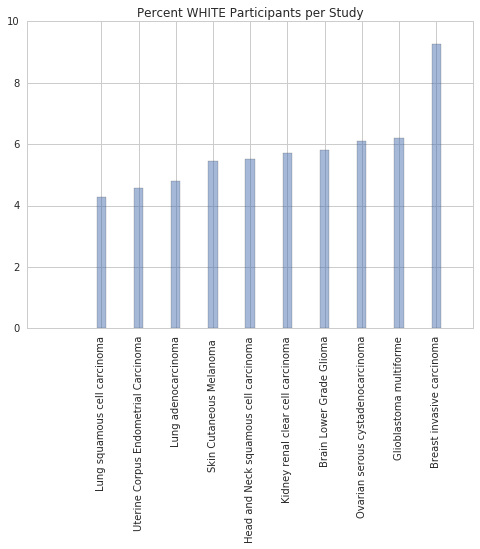

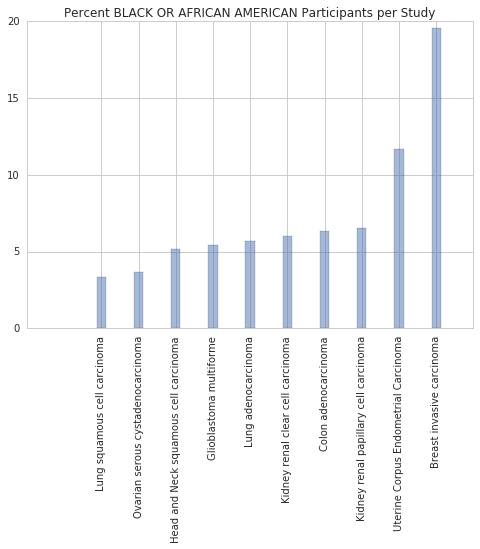

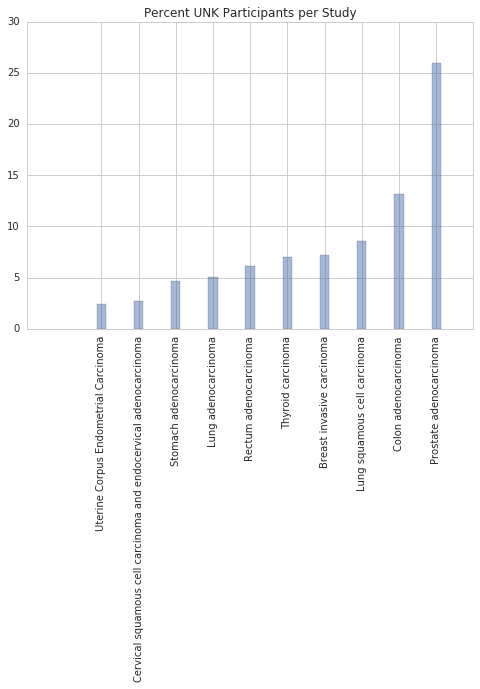

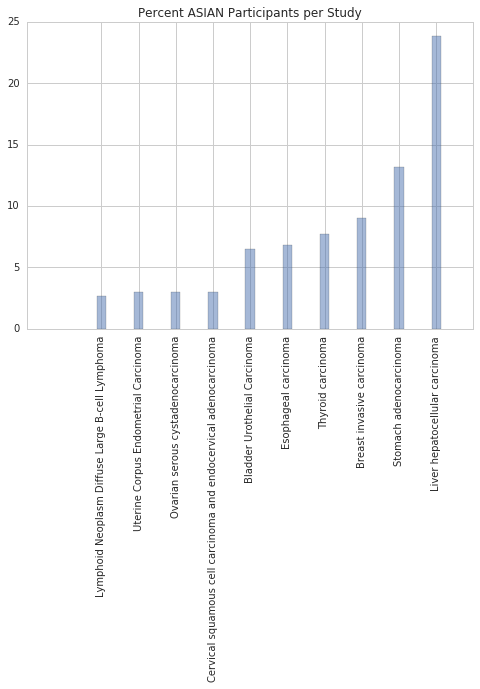

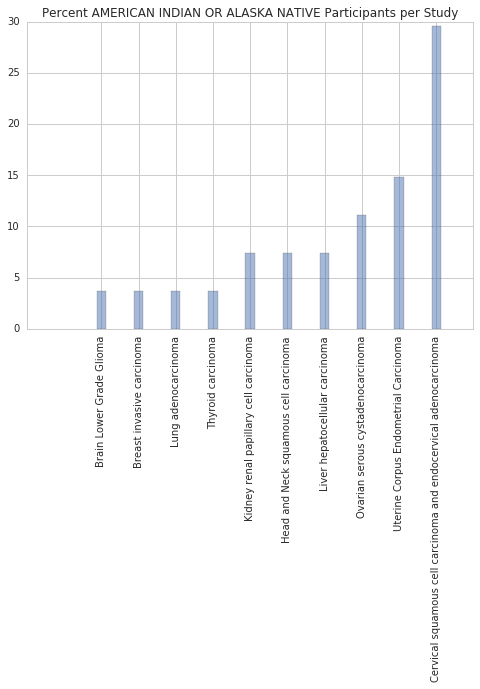

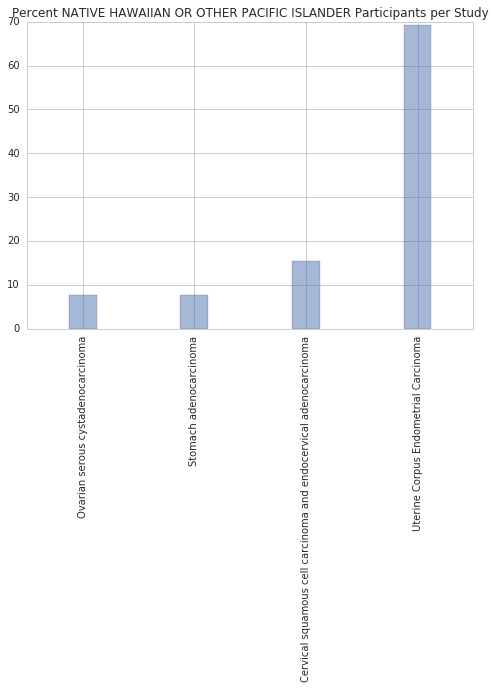

In [51]:
import matplotlib.pyplot as plt

fontsize2use = 10
counter = 1
for r in bq.Query(participant_races).results().to_dataframe().fillna(0)['Race']:
  sub = bq.Query(tumor_type_race_breakdown,race=r).results().to_dataframe().sort_values(by='percent_participants').tail(10)
  plt.bar(left=range(len(sub['Study'])), height=sub['percent_participants'], align='center', alpha=0.5, width=0.25)
  plt.xticks(range(len(sub['Study'])), sub['Study'],fontsize=fontsize2use, rotation=90)
  plt.title("Percent {} Participants per Study".format(r))
  plt.show()

* **Breast Invasive Carcinoma** has the higest percentage of cases within the population of those who identify as White and Black.  
* **Liver hepatocellular carcinoma**, **Cervical squamous cell carcinoma and endocervical adenocarcinoma**, and **Uterine Corpus Endometrial Carcinoma** have the highest percentage of cases for Asian, American Indian or Alaska Native, and American Hawaiian or Other Pacific Islander, respectively. 
* The number of American Indian or Alaska Native and American Hawaiian or Other Pacific Islander identifying participation is significantly lower than other groups.

### General Summary
* Most reprsented demographic appears to be those who identify as White.
* BRCA is the most represented tumor type in TCGA.
* Larger representation from other racial demographics is needed and the lack of representation should be considered when conducting analysis.

__________

## Analysis of Women in Uterine Corpus Endometrial Carcinoma Study

Question(s) to Explore:
* The correlation of menopause status on histological type

In order explore the above questions, a cohort of participants that meet certain criteria should be established.  Information from the Clinical data dataset provides information that suggests a participant should be excluded from analysis -- this could range from a person having recieved prior treatment to matched pairs of tumor and normal tissue being available.  For the purposes of our analysis since we will not be analyzing biospeciman, we will only exclude patients who have received prior treatment.  This information can be found in the Annotations table of the **icb-cgc:tcga_201510_alpha** dataset.  

In [264]:
%%sql
# the diffrent menopause_statuses
SELECT menopause_status
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]
WHERE Study = 'UCEC'
GROUP BY menopause_status

menopause_status
Post (prior bilateral ovariectomy OR >12 mo since LMP with no prior hysterectomy)
Indeterminate (neither Pre or Postmenopausal)
""
Pre (<6 months since LMP AND no prior bilateral ovariectomy AND not on estrogen replacement)
Peri (6-12 months since last menstrual period)


In [266]:
%%sql
# the diffrent histological_types
SELECT histological_type
FROM [isb-cgc:tcga_201510_alpha.Clinical_data]
WHERE Study = 'UCEC'
GROUP BY histological_type

histological_type
Mixed serous and endometrioid
Endometrioid endometrial adenocarcinoma
Serous endometrial adenocarcinoma


* Serous endometrial adenocarcinoma is a more advanced

## Chi-Square Analysis on menopause_status and histological_type

null hypothesis: menopause_status and histological_type are independent
alt hypothesis: menopause_status and histological-type are dependent

Rationale: I would speculate that because menopause status is an age-related status and age increases susceptability to mutations that can cause cancer, that there may exist a correlation between menopause_status and aggressiveness, which is reflected in ovarian histological type.

In [170]:
%%sql --module create_cohort
DEFINE QUERY select_on_annotations
SELECT
  ParticipantBarcode,
  annotationCategoryName AS categoryName,
  annotationClassification AS classificationName
FROM
  [isb-cgc:tcga_201510_alpha.Annotations]
WHERE
  ( itemTypeName="Patient"
    AND (annotationCategoryName="History of unacceptable prior treatment related to a prior/other malignancy"
      OR annotationClassification="Redaction" ) )
GROUP BY
  ParticipantBarcode,
  categoryName,
  classificationName

DEFINE QUERY select_on_clinical
SELECT
  ParticipantBarcode,
  menopause_status,
  histological_type,
FROM
  [isb-cgc:tcga_201510_alpha.Clinical_data]
WHERE
  ( Study="UCEC"
    AND gender="FEMALE"
    AND age_at_initial_pathologic_diagnosis IS NOT NULL
  )

SELECT
  c.menopause_status AS menopause_status,
  c.histological_type AS histological_type
FROM (
  SELECT
    *
  FROM ( $select_on_annotations ) AS a
  OUTER JOIN EACH 
       ( $select_on_clinical ) AS c
  ON
    a.ParticipantBarcode = c.ParticipantBarcode
  WHERE
    (a.ParticipantBarcode IS NOT NULL
      OR c.ParticipantBarcode IS NOT NULL)
  ORDER BY
    a.classificationName,
    a.categoryName,
    a.ParticipantBarcode,
    c.ParticipantBarcode )
WHERE
  ( a.categoryName IS NULL
    AND a.classificationName IS NULL
    AND c.ParticipantBarcode IS NOT NULL )

In [171]:
# drop NaN values
t = bq.Query(create_cohort).results().to_dataframe().dropna()

In [173]:
# check there are no null values
t.isnull().values.any()

False

In [172]:
# take a peek at the data
t.sample(5)

,menopause_status,histological_type
514,Post (prior bilateral ovariectomy OR >12 mo si...,Serous endometrial adenocarcinoma
427,Post (prior bilateral ovariectomy OR >12 mo si...,Serous endometrial adenocarcinoma
187,Post (prior bilateral ovariectomy OR >12 mo si...,Endometrioid endometrial adenocarcinoma
336,Peri (6-12 months since last menstrual period),Endometrioid endometrial adenocarcinoma
222,Post (prior bilateral ovariectomy OR >12 mo si...,Endometrioid endometrial adenocarcinoma


In [181]:
# generate contingency table
contingency_table = pd.crosstab(t.histological_type, t.menopause_status, margins=True)
contingency_table

menopause_status,Indeterminate (neither Pre or Postmenopausal),Peri (6-12 months since last menstrual period),Post (prior bilateral ovariectomy OR >12 mo since LMP with no prior hysterectomy),Pre (<6 months since LMP AND no prior bilateral ovariectomy AND not on estrogen replacement),All
histological_type,,,,,
Endometrioid endometrial adenocarcinoma,16,16,311,34,377
Mixed serous and endometrioid,0,0,20,0,20
Serous endometrial adenocarcinoma,0,1,100,1,102
All,16,17,431,35,499


In [194]:
# confirm array
contingency_table.values

array([[ 16,  16, 311,  34, 377],
       [  0,   0,  20,   0,  20],
       [  0,   1, 100,   1, 102],
       [ 16,  17, 431,  35, 499]])

In [197]:
chi2, p, ddof, expected = scipy.stats.chi2_contingency( contingency_table.values )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi2, p, ddof ) )
print( expected )

Test Statistic: 19.9483073119
p-value: 0.0680701549932
Degrees of Freedom: 12

[[  12.08817635   12.84368737  325.6252505    26.44288577  377.        ]
 [   0.64128257    0.68136273   17.2745491     1.40280561   20.        ]
 [   3.27054108    3.4749499    88.1002004     7.15430862  102.        ]
 [  16.           17.          431.           35.          499.        ]]


* *p-value* > 0.05 therefore fail to reject the null hypothesis and no evidence in this dataset suggests that  menopause_status and histological_type are dependent.

In [312]:
%%sql --module multiple_correlation_analysis
DEFINE QUERY select_on_annotations
SELECT
  ParticipantBarcode,
  annotationCategoryName AS categoryName,
  annotationClassification AS classificationName
FROM
  [isb-cgc:tcga_201510_alpha.Annotations]
WHERE
  ( itemTypeName="Patient"
    AND (annotationCategoryName="History of unacceptable prior treatment related to a prior/other malignancy"
      OR annotationClassification="Redaction" ) )
GROUP BY
  ParticipantBarcode,
  categoryName,
  classificationName

DEFINE QUERY select_on_clinical
SELECT
  ParticipantBarcode,
  menopause_status,
  histological_type,
  race,
  vital_status,
  age_at_initial_pathologic_diagnosis,
  weight,
  BMI
FROM
  [isb-cgc:tcga_201510_alpha.Clinical_data]
WHERE
  ( Study="UCEC"
    AND gender="FEMALE"
    AND age_at_initial_pathologic_diagnosis IS NOT NULL
  )

SELECT
  INTEGER(c.age_at_initial_pathologic_diagnosis / 10) * 10 AS age_at_initial_pathologic_diagnosis,
  c.vital_status AS vital_status,
  c.menopause_status AS menopause_status,
  c.histological_type AS histological_type,
  c.race AS race,
  INTEGER(c.weight / 10) * 10 AS weight,
  INTEGER(c.BMI / 5) * 5 AS bmi
FROM (
  SELECT
    *
  FROM ( $select_on_annotations ) AS a
  OUTER JOIN EACH 
       ( $select_on_clinical ) AS c
  ON
    a.ParticipantBarcode = c.ParticipantBarcode
  WHERE
    (a.ParticipantBarcode IS NOT NULL
      OR c.ParticipantBarcode IS NOT NULL)
  ORDER BY
    a.classificationName,
    a.categoryName,
    a.ParticipantBarcode,
    c.ParticipantBarcode )
WHERE
  ( a.categoryName IS NULL
    AND a.classificationName IS NULL
    AND c.ParticipantBarcode IS NOT NULL )

In [313]:
t = bq.Query(multiple_correlation_analysis).results().to_dataframe().dropna()

In [314]:
t.isnull().values.any()

False

In [300]:
from sklearn.preprocessing import LabelEncoder

In [315]:
vital_status = LabelEncoder()
vital_status.fit(t.vital_status)

menopause_status = LabelEncoder()
menopause_status.fit(t.menopause_status)

histological_type = LabelEncoder()
histological_type.fit(t.histological_type)

race = LabelEncoder()
race.fit(t.race)

LabelEncoder()

In [316]:
vital_status_enc = pd.Series(vital_status.transform(t.vital_status), name='vitual_status')
menopause_enc = pd.Series(menopause_status.transform(t.menopause_status), name='menopause_status')
histological_enc = pd.Series(histological_type.transform(t.histological_type), name='histological_status')
race_enc = pd.Series(race.transform(t.race), name='race')

In [317]:
data_enc = pd.concat([vital_status_enc, menopause_enc, histological_enc, race_enc, t.age_at_initial_pathologic_diagnosis, t.weight, t.bmi], axis=1).dropna()
data_enc.head(7)

,vitual_status,menopause_status,histological_status,race,age_at_initial_pathologic_diagnosis,weight,bmi
0,0.0,2.0,0.0,2.0,50.0,70.0,25.0
1,0.0,2.0,0.0,2.0,50.0,70.0,25.0
2,0.0,2.0,0.0,2.0,60.0,90.0,35.0
4,0.0,2.0,2.0,1.0,60.0,50.0,20.0
5,0.0,2.0,2.0,2.0,50.0,60.0,25.0
6,0.0,2.0,2.0,2.0,60.0,60.0,20.0
7,0.0,2.0,0.0,4.0,70.0,40.0,15.0


In [318]:
data_enc.corr()

,vitual_status,menopause_status,histological_status,race,age_at_initial_pathologic_diagnosis,weight,bmi
vitual_status,1.000000,0.080897,0.211327,0.015560,0.071559,-0.001965,-0.006924
menopause_status,0.080897,1.000000,0.044005,-0.052077,-0.046682,-0.086558,-0.057560
histological_status,0.211327,0.044005,1.000000,-0.047273,0.054187,-0.037151,-0.037905
race,0.015560,-0.052077,-0.047273,1.000000,-0.134984,0.095816,0.083488
age_at_initial_pathologic_diagnosis,0.071559,-0.046682,0.054187,-0.134984,1.000000,-0.269955,-0.220935
weight,-0.001965,-0.086558,-0.037151,0.095816,-0.269955,1.000000,0.932524
bmi,-0.006924,-0.057560,-0.037905,0.083488,-0.220935,0.932524,1.000000


* There is an expected high correlation (0.932524) between BMI (body max index) and weight
* A very weak correlation between vital status and histlogical status.  This makes sense as the more aggressive and advanced a tumor is, the decrease in changes of survival.  
* I expected a stronger correlation at least with age at initial diagnosis and vitual status.
* I expected a stronger correlation between weight/BMI and vitual status or histological_status, as obesity is a known risk factor for endometrial cancer.
* There is very weak negative correlation between age_at_initial_diagnosis and weight/bmi that may somehow tie in the previous point (-0.269955/-0.220935). 

__________

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


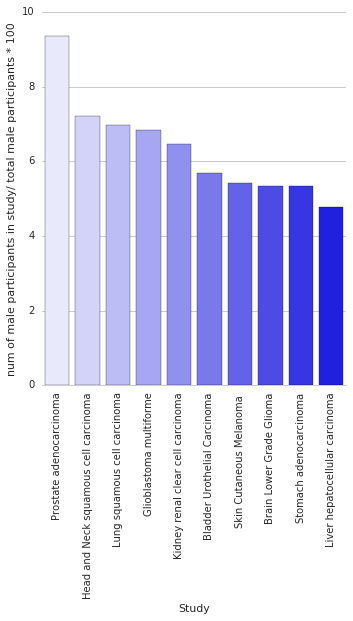

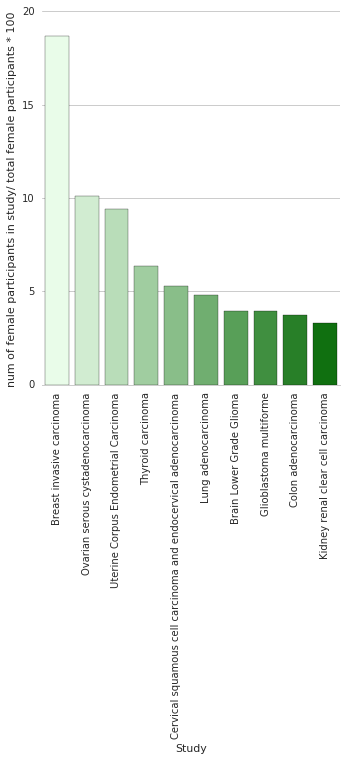

In [46]:
top_tumors_female = females.head(10)
top_tumors_male = males.head(10)
import seaborn as sns
sns.set(style="whitegrid")

# Draw a nested barplot to show survival for class and sex
m = sns.factorplot(x="Study", y="male percent participants", data=top_tumors_male,
                   size=6, kind="bar", palette=sns.light_palette("blue", n_colors=10))
m.despine(left=True)
m.set_ylabels("num of male participants in study/ total male participants * 100")
m.set_xticklabels(rotation=90)

f = sns.factorplot(x="Study", y="female percent participants", data=top_tumors_female,
                   size=6, kind="bar", palette=sns.light_palette("green", n_colors=10))
f.despine(left=True)
f.set_ylabels("num of female participants in study/ total female participants * 100")
f.set_xticklabels(rotation=90)